In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.functional as F
import torch
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from training import Trainer
from load_data import LFWDataLoader

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [3]:
dl = LFWDataLoader(batch_size=64)

train_ds, train_dl = dl.train_dataset, dl.train_dataloader
val_ds, val_dl = dl.val_dataset, dl.val_dataloader
test_ds, test_dl = dl.test_dataset, dl.test_dataloader

(10586, 3, 125, 94)
(1323, 3, 125, 94)
(1324, 3, 125, 94)


In [199]:
from model import Encoder, Decoder, AutoEncoder
from loss import LogCoshLoss

model = AutoEncoder()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

optim = torch.optim.Adam(model.parameters(), lr=5e-4)

trainer = Trainer(model, optim, device, train_dl, val_dl,kl_factor=100,kl_rate=1,kl_max=100)
torch.cuda.empty_cache()
mse, kl, total = trainer.train_model(epochs=6,print_every=100)

5625071
EPOCH:  0
Iteration 0, loss = 420.0250
KL Factor: 100.000000
KL 4.1974
Avg Loss on Val: 0.276438349769229

Iteration 100, loss = 51.4503
KL Factor: 100.000000
KL 0.5141
Avg Loss on Val: 0.038211870761144726

EPOCH:  1
Iteration 0, loss = 51.0660
KL Factor: 100.000000
KL 0.5103
Avg Loss on Val: 0.03353499514716012

Iteration 100, loss = 50.8538
KL Factor: 100.000000
KL 0.5082
Avg Loss on Val: 0.03156421298072452

EPOCH:  2
Iteration 0, loss = 50.6882
KL Factor: 100.000000
KL 0.5066
Avg Loss on Val: 0.031979577881949287

Iteration 100, loss = 50.6010
KL Factor: 100.000000
KL 0.5057
Avg Loss on Val: 0.03106800431296939

EPOCH:  3
Iteration 0, loss = 50.5395
KL Factor: 100.000000
KL 0.5051
Avg Loss on Val: 0.032296444688524516

Iteration 100, loss = 50.5077
KL Factor: 100.000000
KL 0.5048
Avg Loss on Val: 0.03047261635462443

EPOCH:  4
Iteration 0, loss = 50.4160
KL Factor: 100.000000
KL 0.5038
Avg Loss on Val: 0.032842880203610376

Iteration 100, loss = 50.3935
KL Factor: 100.0000

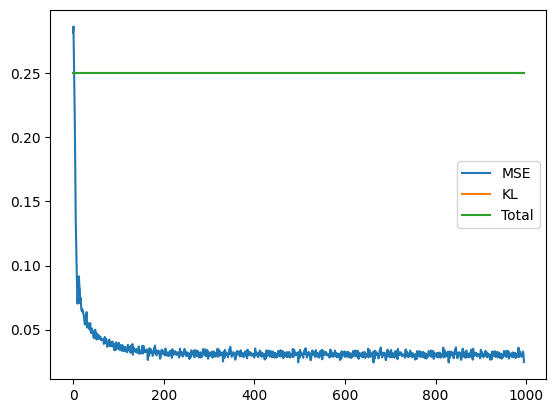

In [200]:
total = np.minimum(total,0.25)
kl = np.minimum(kl,0.25)

plt.plot(range(len(mse)),mse,label='MSE')
plt.plot(range(len(kl)),kl,label='KL')
plt.plot(range(len(total)),total,label='Total')
plt.legend()

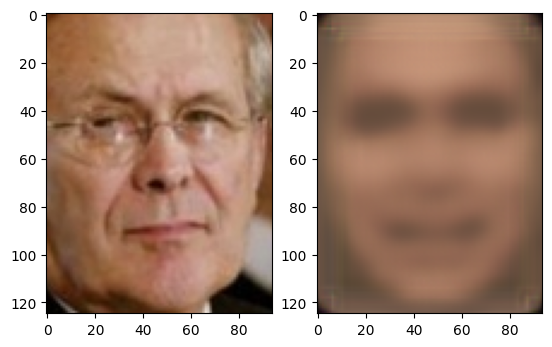

In [201]:
f = plt.figure()
tensor_image, = test_ds[20]
f.add_subplot(1,2,1)
plt.imshow(tensor_image.permute(1, 2, 0))
model.eval()
with torch.no_grad():
    tensor_image = tensor_image.unsqueeze(0)
    scores,_ = model(tensor_image.to(device))

f.add_subplot(1,2,2)
scores = scores.squeeze(0)
plt.imshow(scores.to('cpu').permute(1, 2, 0))

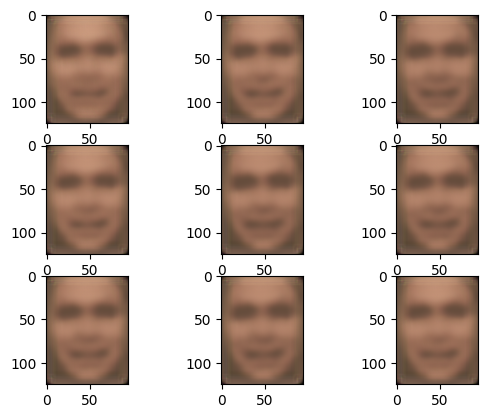

In [202]:
encoder = model.encoder
decoder = model.decoder
with torch.no_grad():
    randomData = torch.Tensor(np.random.normal(0,1,(9,20)))
    scores = model.decoder(randomData.to(device))
f = plt.figure()
for i in range(9):
    f.add_subplot(3,3,i+1)
    plt.imshow(scores[i].squeeze(0).to('cpu').permute(1, 2, 0))

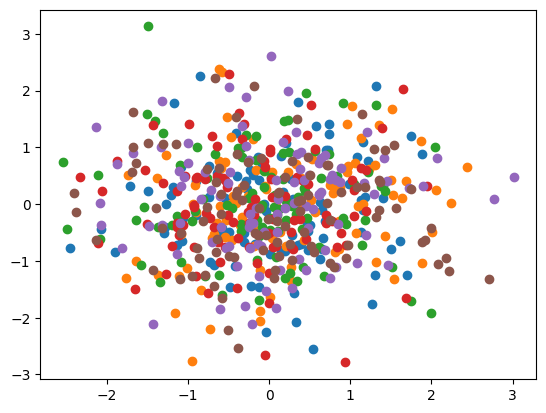

In [211]:
encoder = model.encoder
tensor_image, = test_ds[:6]
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu').detach()
latent_mu = latent_mu.to('cpu').detach()
for i in range(6):
    latent_dist = torch.distributions.Normal(latent_mu[i,0],torch.abs(latent_var[i,0]))
    latent_dist_2 = torch.distributions.Normal(latent_mu[i,1],torch.abs(latent_var[i,1]))
    # plt.scatter(np.abs(latent_var[:,i]),np.abs(latent_var[:,i+1]))
    plot1,plot2 = [],[]
    for i in range(100):
        plot1.append(latent_dist.rsample())
        plot2.append(latent_dist_2.rsample())
    plt.scatter(plot1,plot2)

In [44]:
import gc 
model = 1
del model 
gc.collect()
plt.close()
with torch.no_grad():
    torch.cuda.empty_cache()